# PINN-THM solver thermoelastic consolidation of an unsaturated stratum using sequential stress-split training 

Check out our paper for more details: 
**Physics-informed neural network solution of thermo-hydro-mechanical (THM) processes in porous media**

Find the paper at: [https://arxiv.org/abs/2203.01514](https://arxiv.org/abs/2203.01514)

Try it out on Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciann/sciann-applications/blob/master/SciANN-PoroElasticity/PINN_THM_TwoPhaseConsolidation.ipynb)


Cite our work:
```
@article{amini2022physics,
  title={Physics-informed neural network solution of thermo-hydro-mechanical (THM) processes in porous media},
  author={Amini, Danial and Haghighat, Ehsan and Juanes, Ruben},
  journal={arXiv preprint arXiv:2203.01514},
  year={2022}
}
```

<!-- # PINN solver for Mandel's poroelasticity problem using sequential stress-split training 

Check out our paper for more details: 
**Physics-informed neural network simulation of multiphase poroelasticity using stress-split sequential training**

Find the paper at: [https://arxiv.org/abs/2110.03049](https://arxiv.org/abs/2110.03049)

Try it out on Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciann/sciann-applications/blob/master/SciANN-PoroElasticity/PINN_PoroElasticity_Mandel.ipynb)


Cite our work:
```
@article{haghighat2021physics,
  title={Physics-informed neural network simulation of multiphase poroelasticity using stress-split sequential training},
  author={Haghighat, Ehsan and Amini, Danial and Juanes, Ruben},
  journal={arXiv preprint arXiv:2110.03049},
  year={2021}
}
``` -->

In [6]:
!pip install sciann==0.6.5.1 -q 

In [2]:
import numpy as np 
import sciann as sn 
from sciann.utils.math import sign, abs, sigmoid, tanh, diff
import os, time 
import matplotlib.pyplot as plt

---------------------- SCIANN 0.6.5.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0] 



In [3]:
#@title
# #@title Data generator block  
class DataGeneratorXT:
  """ Generates 1D time-dependent collocation grid for training PINNs
  Taken from here: https://github.com/sciann/sciann-applications/tree/master/SciANN-DataGenerator 
  # Arguments:
    X: [X0, X1]
    T: [T0, T1]
    targets: list and type of targets you wish to impose on PINNs. 
        ('domain', 'ic', 'bc-left', 'bc-right', 'all')
    num_sample: total number of collocation points. 
    logT: generate random samples logarithmic in time. 
  # Examples: 
    >> dg = DataGeneratorXT([0., 1.], [0., 1.], ["domain", "ic", "bc-left", "bc-right"], 10000)
    >> input_data, target_data = dg.get_data()
  """
  def __init__(self, 
               X=[0., 1.],
               T=[0., 1.],
               targets=['domain', 'ic', 'bc-left', 'bc-right'], 
               num_sample=10000,
               logT=False):
    'Initialization'
    self.Xdomain = X
    self.Tdomain = T
    self.logT = logT
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_uniform_T_samples(self, num_sample):
    if self.logT is True:
      t_dom = np.random.uniform(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), num_sample)
      t_dom = np.exp(t_dom) - 1.
    else:
      t_dom = np.random.uniform(self.Tdomain[0], self.Tdomain[1], num_sample)
    return t_dom

  def generate_data(self):
    # Half of the samples inside the domain.
    num_sample = int(self.num_sample/2)
    
    counter = 0
    # domain points 
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_dom = self.generate_uniform_T_samples(num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # The other half distributed equally between BC and IC.
    num_sample = int(self.num_sample/4)

    # initial conditions
    x_ic = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_ic = np.full(num_sample, self.Tdomain[0])
    ids_ic = np.arange(x_ic.shape[0]) + counter 
    counter += ids_ic.size

    # bc points 
    num_sample_per_edge = int(num_sample/2)
    # left bc points 
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    t_bc_left = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points 
    x_bc_right = np.full(num_sample-num_sample_per_edge, self.Xdomain[1])
    t_bc_right = self.generate_uniform_T_samples(num_sample-num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter 
    counter += ids_bc_right.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right])
    ids_all = np.concatenate([ids_dom, ids_ic, ids_bc])

    ids = {
        'domain': ids_dom, 
        'bc-left': ids_bc_left, 
        'bc-right': ids_bc_right,
        'ic': ids_ic,
        'bc': ids_bc, 
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_ic, x_bc_left, x_bc_right]).reshape(-1,1),
        np.concatenate([t_dom, t_ic, t_bc_left, t_bc_right]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )
      
    return input_data, target_data

  def get_test_grid(self, Nx=200, Nt=200):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    if self.logT:
      ts = np.linspace(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), Nt)
      ts = np.exp(ts) - 1.0
    else:
      ts = np.linspace(self.Tdomain[0], self.Tdomain[1], Nt)
    return np.meshgrid(xs, ts)

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      t_data = self.input_data[1][ids,:]
      plt.scatter(x_data, t_data)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        t_data = self.input_data[1][t_idx,:]
        plt.scatter(x_data, t_data, label=t, c=next(cycol))
      plt.xlabel('x')
      plt.ylabel('t')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()

In [4]:
# Unit conversions 
s, minute, hr, day = 1., 60., 60.**2, 24*60.**2
g, kg = 1.e-3, 1.
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9
micro, milli, centi, kilo, mega = 1e-6, 1e-3, 1e-2, 1e3, 1e6
poise = 0.1*Pa*s
Darcy = 9.869233e-13*m**2

In [5]:
# ----------------------- Constant Parameters-----------------------
DTYPE = 'float32'

E = 60e6
nu = 0.2857
phi = 0.5
b = 1.0
rho_s, rho_w, rho_g = 1800.0 * kg/m**3, 1000 * kg/m**3, 1.22 * kg/m**3
rho_t = (1 - phi)*rho_s + phi*0.5*rho_w + phi*0.5*rho_g
Ks, Kw, Kg = (0.14e10) *Pa, (0.43e13) *Pa, (0.1e6) *Pa               
cw, cg = 1/Kw, 1/Kg                      
k = (6e-15) *m**2            
mu_w, mu_g = (1e-3) *Pa*s, (1e-3) *Pa*s          
mu = mu_w + mu_g 
mu_r_w, mu_r_g = mu/mu_w, mu/mu_g
g = 0.0 *m/s**2              
p_atm = 0.0 *Pa       
Ly = 0.1*m            
Kdr = E/(3*(1-2*nu))
Sw_ini, Sg_ini, Srw, p_bubl = 0.445, 0.555, 0.3216, 133.8 *kPa

p_star = 420 *kPa
x_star = Ly
pwd_top, pcd_top = -420*kPa/p_star, 420*kPa/p_star
pwd_ini, pcd_ini = -280*kPa/p_star, 280*kPa/p_star
beta_s, beta_w, beta_g = 0.9e-6, 6.3e-6, 3.3e-3

C_s, C_w, C_g = 125460, 4182, 1000

Lambda_avg = 0.458     


In [ ]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(124)

yd = sn.Variable('yd', dtype=DTYPE)
td = sn.Variable('td', dtype=DTYPE)

pwd = sn.Functional('pwd', [yd, td], 8*[40], 'tanh') 
pcd = sn.Functional('pcd', [yd, td], 8*[40], 'tanh') 
vd = sn.Functional('vd', [yd, td], 8*[40], 'tanh') 
Evd = sn.Functional('Evd', [yd, td], 8*[40], 'tanh')
Td = sn.Functional('Td', [yd, td], 8*[40], 'tanh')

pcd_p = 0.5*(1 + sign(pcd - (pcd_ini)))*pcd + 0.5*(1 - sign(pcd - (pcd_ini)))*(pcd_ini)
pgd = pcd + pwd

In [ ]:
# ----------------------- Saturation Relations -----------------------
S_power = 2.308
Sw = Srw + (1 - Srw)*((p_bubl/(pcd_p*p_star))**S_power)
dSw_dpcd = (1 - Srw)*((p_bubl/p_star)**S_power)*(-S_power)*(pcd_p**(-S_power-1))
Se =(Sw - Srw)/(1 - Srw)
krw = Se**((2+3*S_power)/S_power)
krg = ((1-Se)**2)*(1-Se**((2+S_power)/3))
Sg = 1 - Sw


rho_C_avg = (1-phi)*rho_s*C_s + Sw*phi*rho_w*C_w + Sg*phi*rho_g*C_g
rho_C = (1-phi)*rho_s*C_s + 0.5*phi*rho_w*C_w + 0.5*phi*rho_g*C_g
rho_C_avg_r = rho_C_avg/rho_C
rho_C_w_r = rho_w*C_w/rho_C
rho_C_g_r = rho_g*C_g/rho_C


# ----------------------- Dimensionless parameter -----------------------
M = 1/(phi*0.5*cw + phi*0.5*cg + (b - phi)/Ks) 
M_bar = 1/((b**2/Kdr)+(1/M))
t_star = 1000*hr 
u_star = p_star*x_star/Kdr
T_star = 15
beta_s_w = Sw*((b-phi)*beta_s + phi*beta_w)
beta_s_g = Sg*((b-phi)*beta_s + phi*beta_g)
nu_star = (1 - 2*nu)/(1 + nu)


y = yd*x_star    
pw = pwd*p_star
pc = pcd*p_star
t = td*t_star   
v = vd*u_star    
T = Td*T_star


td_0 = 0.0
td_f = 1.0 
yd_min = 0.0 
yd_max = (Ly/x_star) 


N_T = beta_s*Kdr*T_star/p_star
Nd = x_star*rho_t*g/p_star
A_star = mu*(x_star**2)/(k*t_star*M_bar)
D_star_w = Sw*b*mu*(x_star**2)/(Kdr*k*t_star)
D_star_g = Sg*b*mu*(x_star**2)/(Kdr*k*t_star)
Q_star_w = (beta_s_w - b*Sw*beta_s)*T_star*mu*(x_star**2)/(t_star*k*p_star) 
Q_star_g = (beta_s_g - b*Sg*beta_s)*T_star*mu*(x_star**2)/(t_star*k*p_star) 
C_star = rho_C*(x_star**2)/(Lambda_avg*t_star)
J_star = (rho_C/Lambda_avg)*(k*p_star/mu)


N = (b - phi)*(1 - b)/Kdr
Ngg = -phi*dSw_dpcd/p_star + phi*Sg*cg + (Sg**2)*N
Nwg = phi*dSw_dpcd/p_star + Sw*Sg*N
Nww = -phi*dSw_dpcd/p_star + phi*Sw*cw + (Sw**2)*N


In [ ]:
# ----------------------- Solid Mechanics -----------------------

Svd = Evd - b*(pwd+Sg*pcd - (pwd_ini+Sg_ini*pcd_ini)) - N_T*Td
Svd_td = diff(Svd, td)
Syyd = Evd + 2*nu_star*diff(vd, yd) - b*(pwd+Sg*pcd - (pwd_ini+Sg_ini*pcd_ini)) - N_T*Td
                   
Msy = sn.rename(diff(Evd, yd) + 2*nu_star*diff(vd, yd, order=2) - b*diff(pwd+Sg*pcd, yd) - N_T*diff(Td, yd), "Msy")
MEv = sn.rename(Evd - diff(vd, yd), "MEv")

C_v_ini = sn.rename((td == td_0)*abs(vd), "C_v_ini")
C_v_bc_1 = sn.rename((yd == yd_max)*abs(Syyd), "C_v_bc_1")
C_v_bc_2 = sn.rename((yd == yd_min)*abs(vd), "C_v_bc_2")

targets_solid = [sn.PDE(Msy), sn.PDE(MEv), C_v_ini, C_v_bc_1, C_v_bc_2]

In [ ]:
# ----------------------- Fluid Mechanics -----------------------

Svd_td_seq = sn.Variable('Svd_td_seq', dtype=DTYPE)
pwd_yd, pwd_td = diff(pwd, yd), diff(pwd, td)
pcd_yd, pcd_td = diff(pcd, yd), diff(pcd, td)
pgd_yd, pgd_td = diff(pgd, yd), diff(pgd, td)
bw, bg = b*Sw, b*Sg

Mp_wet = sn.rename((Nww+Nwg+(bw*bw+bw*bg)/Kdr)*M_bar*A_star*pwd_td + (Nwg+bw*bg/Kdr)*M_bar*A_star*pcd_td + D_star_w*Svd_td_seq 
                   - Q_star_w*diff(Td, td) - mu_r_w*(diff(krw*pwd_yd,yd)), "Mp_wet")

Mp_nonwet = sn.rename((Nwg+Ngg+(bg*bg+bw*bg)/Kdr)*M_bar*A_star*pwd_td + (Ngg+bg*bg/Kdr)*M_bar*A_star*pcd_td + 
                      D_star_g*Svd_td_seq - Q_star_g*diff(Td, td) - mu_r_g*(diff(krg*pgd_yd,yd)), "Mp_nonwet")

C_pw_ini = sn.rename((td == td_0)*abs(pwd - pwd_ini), "C_pw_ini")
C_pc_ini = sn.rename((td == td_0)*abs(pcd - pcd_ini), "C_pc_ini")

C_pw_bc_1 = sn.rename((yd == yd_max)*abs(pwd - pwd_top), "C_pw_bc_1")
C_pw_bc_2 = sn.rename((yd == yd_min)*abs(pwd_yd), "C_pw_bc_2")

C_pc_bc_1 = sn.rename((yd == yd_max)*abs(pcd - pcd_top), "C_pc_bc_1")
C_pc_bc_2 = sn.rename((yd == yd_min)*abs(pcd_yd), "C_pc_bc_2")


targets_fluid = [sn.PDE(Mp_wet), sn.PDE(Mp_nonwet), C_pw_ini, C_pc_ini, C_pw_bc_1, C_pw_bc_2 , C_pc_bc_1, C_pc_bc_2] 


In [ ]:
# ----------------------- Energy Balance -----------------------

Td_yd, Td2_yd2, Td_td = diff(Td,yd), diff(Td, yd, order=2), diff(Td,td)

MT = sn.rename(rho_C_avg_r*C_star*Td_td - J_star*(rho_C_g_r*mu_r_g*krg*diff(pgd, yd) + rho_C_w_r*mu_r_w*krw*diff(pwd, yd))*Td_yd - Td2_yd2, "MT")

C_T_ini = sn.rename((td == td_0)*abs(Td), "C_T_ini")
C_T_bc_1 = sn.rename((yd == yd_max)*abs(Td - 15/T_star), "C_T_bc_1")
C_T_bc_2 = sn.rename((yd == yd_min)*abs(Td_yd), "C_T_bc_2")


targets_energy = [sn.PDE(MT), C_T_ini, C_T_bc_1, C_T_bc_2]    

In [ ]:
# ----------------------- prediction model -----------------------
model_pred = sn.SciModel([yd, td], [Td, pwd, pcd, vd])

# ----definition of models for sequential process-------

solid = sn.SciModel([yd, td], targets_solid)
fluid = sn.SciModel([yd, td, Svd_td_seq], targets_fluid)
thermal = sn.SciModel([yd, td], targets_energy)

#------training parameters---------
BATCH_SIZE = 1000          # higher batch size results in more accuracy
NUM_SAMPLES = 10000        #100000
EPOCHS_FLUID = 1000        # make sure (NUM_SAMPLES/BATCH_SIZE)*EPOCHS > 100K (total gradient updates)
EPOCHS_SOLID = 1000        # make sure (NUM_SAMPLES/BATCH_SIZE)*EPOCHS > 100K (total gradient updates)
EPOCHS_THERMAL = 1000      # make sure (NUM_SAMPLES/BATCH_SIZE)*EPOCHS > 100K (total gradient updates)
STOP_AFTER = None

ADAPTIVE_WEIGHTS_THERMAL = {'method': 'GP', 'freq': 300}

ADAPTIVE_WEIGHTS_FLUID = {'method': 'GN', 'freq': 300, 'use_score': True, 'alpha': 2.0}

ADAPTIVE_WEIGHTS_SOLID = {'method': 'GN', 'freq': 300, 'use_score': True, 'alpha': 1.0}

initial_lr = 1e-3
final_lr = initial_lr/100

LEARNING_RATE_FLUID = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": EPOCHS_FLUID
}

LEARNING_RATE_SOLID = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": EPOCHS_SOLID
}

LEARNING_RATE_THERMAL = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": EPOCHS_THERMAL
}


dg_solid = DataGeneratorXT(
    X=[yd_min, yd_max], T=[td_0, td_f],
    num_sample=NUM_SAMPLES,
    targets=['domain', 'domain', 'ic', 'bc-right', 'bc-left']
)
input_data_solid, target_data_solid = dg_solid.get_data()


dg_fluid = DataGeneratorXT(
    X=[yd_min, yd_max], T=[td_0, td_f],
    num_sample=NUM_SAMPLES,
    targets=['domain', 'domain', 'ic', 'ic', 'bc-right', 'bc-left', 'bc-right', 'bc-left']
)
input_data_fluid, target_data_fluid = dg_fluid.get_data()


dg_thermal = DataGeneratorXT(
    X=[yd_min, yd_max], T=[td_0, td_f],
    num_sample=NUM_SAMPLES,
    targets=['domain', 'ic', 'bc-right', 'bc-left']
)
input_data_thermal, target_data_thermal = dg_thermal.get_data()

In [ ]:
#@title Postprocessing data 
# -----------grid for evaluation of the trained model-------------

log10p = lambda x: np.log10(1. + x)
Ny, Nt = 100, 301
ys = np.linspace(yd_min, yd_max, Ny)
ys_lineplot = ys
ts_lineplot = [1*hr/t_star,5*hr/t_star,10*hr/t_star,50*hr/t_star,100*hr/t_star,
               200*hr/t_star,300*hr/t_star,500*hr/t_star,1000*hr/t_star]

input_test_lineplot = np.meshgrid(ys_lineplot, ts_lineplot, indexing='ij')

#----plot settings------
subplot_adust = [0.1, 0.15, 0.85, 0.85, 0.25, 0.25]

legend_settings = {
    'title': "Time (hr)",
    'bbox_to_anchor': (1.025, 1),
    'loc': 'upper left',
    'fontsize': 'medium',
    'fancybox': True,
    'frameon': False
}

label = ['1', '5', '10', '50', '100', '200', '300', '500', '1000']

In [ ]:
#@title Post processing (plotting) functions 

def plot_results(ts_lineplot, ys_lineplot, PINN_U, PINN_Pc, PINN_T, itr):
    
    fig, ax = plt.subplots(1,3, figsize=(12, 3.5))
    for i in range(np.size(ts_lineplot)):
        ax[0].plot(ys_lineplot*x_star, PINN_U[:,i], ls='--')
        ax[1].plot(ys_lineplot*x_star, PINN_Pc[:,i], ls='--')
        ax[2].plot(ys_lineplot*x_star, PINN_T[:,i], ls='--', label=label[i])
    
    ax[0].set_xlabel('Height (m)'), ax[1].set_xlabel('Height (m)'), ax[2].set_xlabel('Height (m)')
    ax[0].set_ylabel('Vertical Displacement (m)')
    ax[1].set_ylabel('Capillary Pressure (kPa)')
    ax[2].set_ylabel('Temperature  ${(T~-~T_0)}$ $({}^o K)$')

    ax[0].set_ylim(-4e-5,0.25e-5), ax[1].set_ylim(275,425), ax[2].set_ylim(-0.5, 16.5)
    ax[0].grid(True, ls='--'), ax[1].grid(True, ls='--'), ax[2].grid(True, ls='--')
    ax[2].legend(**legend_settings)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3)
    plt.savefig('results_itr{:02d}.jpg'.format(itr + 1), dpi=150)
    plt.show()
    plt.close()  


    
def cust_semilogx(AX, X, Y, xlabel, ylabel, title, line_label=None):
    if X is None:
        im = AX.semilogy(Y, label=line_label)
    else:
        im = AX.semilogy(X, Y, label=line_label)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title  is not None: AX.set_title(title)  
    
    
def plot_loss_itr(H_fluid, H_solid, H_thermal, itr):
    fig, ax = plt.subplots(3, 3, figsize=(12, 10))
    for key, val in H_fluid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[0, 0], None, np.array(val) / val[0], None, "Fluid", "L/L0", key)
    ax[0, 0].legend(loc="upper right")
    cust_semilogx(ax[0, 1], None, np.array(H_fluid.history["lr"]), None, None, "lr")
    cust_semilogx(ax[0, 2], None, np.array(H_fluid.history["time"]), None, None, "time")
    
    for key, val in H_solid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[1, 0], None, np.array(val) / val[0], None, "Solid", None, key)
    ax[1, 0].legend(loc="upper right")
    cust_semilogx(ax[1, 1], None, np.array(H_solid.history["lr"]), None, None, None)
    cust_semilogx(ax[1, 2], None, np.array(H_solid.history["time"]), None, None, None)
    
    for key, val in H_thermal.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[2, 0], None, np.array(val) / val[0], "Epoch", "Thermal", None, key)
    ax[2, 0].legend(loc="upper right")
    cust_semilogx(ax[2, 1], None, np.array(H_thermal.history["lr"]), "Epoch", None, None)
    cust_semilogx(ax[2, 2], None, np.array(H_thermal.history["time"]), "Epoch", None, None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('losses_itr{:02d}.jpg'.format(itr + 1), dpi=150)
    plt.show()
    plt.close()
    


In [ ]:
# ---------------------Sequential Training Algorithm---------------------------
n_itr = 3

loss_fluid, loss_solid, loss_thermal = [], [], []
lr_fluid, lr_solid, lr_thermal = [], [], []
time_fluid, time_solid, time_thermal = [], [], []

Sv_evaluation = np.zeros_like(input_data_fluid[0])
start_time = time.time()

for itr in range(n_itr):

    itr_time = time.time()
    if itr == 0:
        kwrds_thermal = {'adaptive_weights': ADAPTIVE_WEIGHTS_THERMAL}
        kwrds_fluid = {'adaptive_weights': ADAPTIVE_WEIGHTS_FLUID}
        kwrds_solid = {'adaptive_weights': ADAPTIVE_WEIGHTS_SOLID}
    
    else:
        kwrds_thermal = {}
        kwrds_fluid = {}
        kwrds_solid = {}
    
    #---training thermal-------
    vd.set_trainable(False)
    Evd.set_trainable(False)
    Td.set_trainable(True)
    pwd.set_trainable(False)
    pcd.set_trainable(False)
    thermal.compile()
    
    H_thermal = thermal.train(
        input_data_thermal, 
        target_data_thermal,
        learning_rate=LEARNING_RATE_THERMAL,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS_THERMAL,
        stop_loss_value=1e-8,
        stop_after=STOP_AFTER,
        verbose=0,
        **kwrds_thermal
    )
    thermal.save_weights('thermal_weights_itr{:02d}.hdf5'.format(itr + 1))

    
    #-----training fluid-------
    vd.set_trainable(False)
    Evd.set_trainable(False)
    Td.set_trainable(False)
    pwd.set_trainable(True)
    pcd.set_trainable(True)
    fluid.compile()
    
    H_fluid = fluid.train(
        input_data_fluid+[Sv_evaluation],
        target_data_fluid,
        learning_rate=LEARNING_RATE_FLUID,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS_FLUID,
        stop_loss_value=1e-8,
        stop_after=STOP_AFTER,
        verbose=0,
        **kwrds_fluid
    )
    
    fluid.save_weights('fluid_weights_itr{:02d}.hdf5'.format(itr + 1))
    
    
    #----training solid-----
    vd.set_trainable(True)
    Evd.set_trainable(True)
    Td.set_trainable(False)
    pwd.set_trainable(False)
    pcd.set_trainable(False)
    solid.compile()
    
    H_solid = solid.train(
        input_data_solid,
        target_data_solid,
        learning_rate=LEARNING_RATE_SOLID,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS_SOLID,
        stop_loss_value=1e-8,
        stop_after=STOP_AFTER,
        verbose=0,
        **kwrds_solid
    )
    solid.save_weights('solid_weights_itr{:02d}.hdf5'.format(itr + 1))
    
    Sv_evaluation = Svd_td.eval(model_pred, input_data_fluid)
    
    
    loss_fluid += H_fluid.history["loss"]
    loss_solid += H_solid.history["loss"]
    loss_thermal += H_thermal.history["loss"]
    lr_fluid += H_fluid.history["lr"]
    lr_solid += H_solid.history["lr"]
    lr_thermal += H_thermal.history["lr"]
    time_fluid += H_fluid.history["time"]
    time_solid += H_solid.history["time"]
    time_thermal += H_thermal.history["time"]

    print('\n -- iteration {} is completed in {}s, total in {}s... \n'.format(
        itr + 1, time.time() - itr_time, time.time() - start_time)
    )

    
    #--------evaluation and plot-----------
    PINN_U = (vd.eval(model_pred, input_test_lineplot))*u_star/m
    PINN_Pc = (pcd.eval(model_pred, input_test_lineplot))*p_star/kPa
    PINN_T = (Td.eval(model_pred, input_test_lineplot))*T_star
    


Total samples: 10000 
Batch size: 1000 
Total batches: 10 


+ adaptive_weights at epoch 1: [0.9053191597427382, 1.1755525181079596, 0.9535845424804752, 0.9655437796688271]

+ adaptive_weights at epoch 301: [0.8164512444318454, 1.1010289205486197, 0.8975139726454919, 1.1850058623740432]

+ adaptive_weights at epoch 601: [0.7348773527546153, 0.995789329604716, 0.8154337460477004, 1.4538996252371486]

+ adaptive_weights at epoch 901: [0.6615563368555032, 0.901519797045281, 0.7414222893484115, 1.6955016303949848]

Total samples: 10000 
Batch size: 1000 
Total batches: 10 


+ adaptive_weights at epoch 1: [1.6999390526142373, 0.9000010012767532, 0.9000030337944497, 0.9000020256086444, 0.9000015496929425, 0.9000484170801537, 0.9000013650354688, 0.9000035548973506]

+ adaptive_weights at epoch 301: [2.3299450972110805, 0.8100008905055904, 0.8100027144370803, 0.8100018025062214, 0.810001373394822, 0.8100436041787368, 0.8100012128259436, 0.8100031976521643]

+ adaptive_weights at epoch 601: [


+ adaptive_weights at epoch 301: [0.8648461719066268, 1.0819859114765706, 1.7407025234326616, 0.7619881716195758, 0.5504771679203848]

+ adaptive_weights at epoch 601: [0.8912482256802889, 1.0077805163493108, 1.7437078940260744, 0.8272804235743059, 0.52998288672584]

+ adaptive_weights at epoch 901: [0.884793348478124, 1.0544486583157562, 1.7365966526725982, 0.8310509148714764, 0.4931103720178649]

 -- iteration 3 is completed in 5230.731285810471s, total in 10130.452270030975s... 



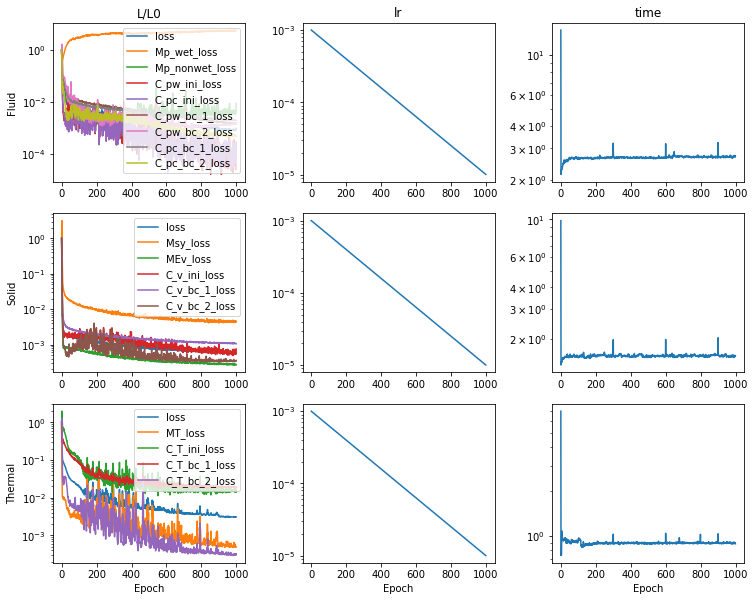

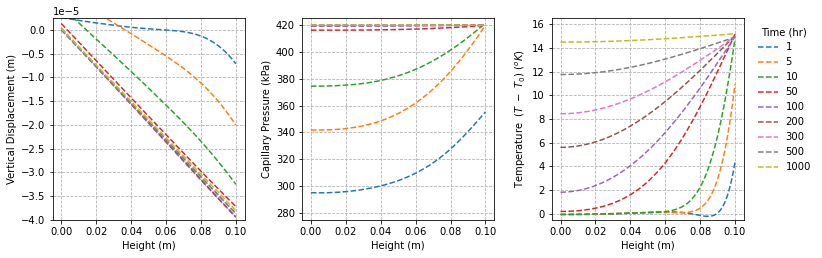

In [ ]:

plot_loss_itr(H_fluid, H_solid, H_thermal, itr)

plot_results(ts_lineplot, ys_lineplot, PINN_U, PINN_Pc, PINN_T, itr)